In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import fftpack
from tqdm.notebook import tqdm
from numpy.fft import fft
import random
from scipy.io import wavfile
from scipy import signal
from scipy.stats import multivariate_normal

In [2]:
# window specs
WINDOW = 400 # in samples 
SHIFT  = 160 # in samples

# Import Training data
## First part - Loading Speech files

In [3]:
# import speech data and apply FFt , window = hamming, hop_length = 160, Window_size = 400
x_speech = []
entries = os.listdir('train/speech/')
for entry in tqdm(range(len(entries))):
    sr,data = wavfile.read(os.path.join("train/speech/"+ entries[entry]))
    pad = np.array(np.zeros(80).T)  # padding applied
    data = np.append(data,pad)
    window = signal.hamming(400)  # window for applying FFT
    for i in range(0,len(data)-WINDOW+SHIFT,SHIFT):
        temp = np.array(data[i:i+400]).astype(float)
        #print(window.shape)
        temp = temp * window
        temp_fft = np.log(np.abs(fft(temp,64)[:32]))  # 64 component magnitude FFT
        if entry==0 and i==0:
            Speech = temp_fft.T.reshape(32,1)
            #print(speech_specto.shape)
            continue
        Speech = np.concatenate((Speech,temp_fft.reshape(32,1)),axis=1)



(32, 119960)


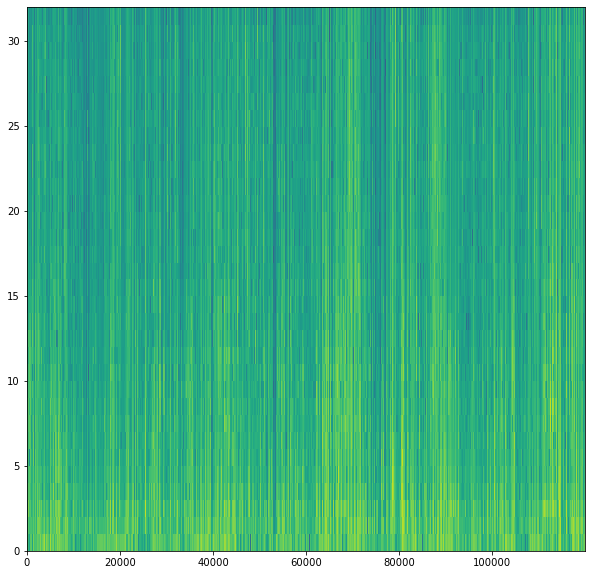

In [4]:
plt.figure(figsize=(10,10))
plt.pcolormesh(Speech)
print(Speech.shape)
#Speech = Speech[:,1:] # shape = (32,119960)

In [5]:
Speech.shape

(32, 119960)

## Second part - Loading Music files


(32, 119960)


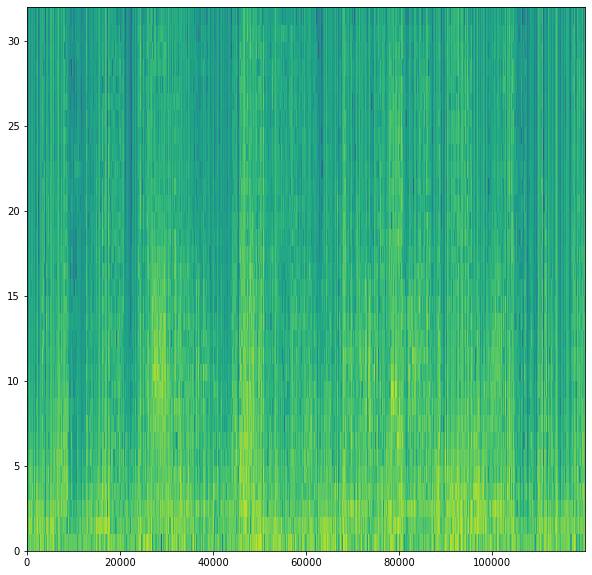

In [6]:
# import Music data and apply FFt , window = hamming, hop_length = 160, Window_size = 400
x_music = []
entries = os.listdir('train/music/')
for entry in tqdm(range(len(entries))):
    sr,data = wavfile.read(os.path.join("train/music/"+ entries[entry]))
    pad = np.array(np.zeros(80).T)  # padding applied
    data = np.append(data,pad)
    window = signal.hamming(400)  # window for applying FFT
    for i in range(0,len(data)-WINDOW+SHIFT,SHIFT):
        temp = np.array(data[i:i+400]).astype(float)
        #print(window.shape)
        temp = temp * window
        temp_fft = np.log(np.abs(fft(temp,64)[:32]))  # 64 component magnitude FFT
        if entry==0 and i==0:
            Music = temp_fft.T.reshape(32,1)
            #print(speech_specto.shape)
            continue
        Music = np.concatenate((Music,temp_fft.reshape(32,1)),axis=1)

#Music = Music[:,1:]     # shape = (32,119960)
plt.figure(figsize=(10,10))
print(Music.shape)
plt.pcolormesh(Music)

In [7]:
Music.shape

(32, 119960)

# Import test data


(32, 143952)


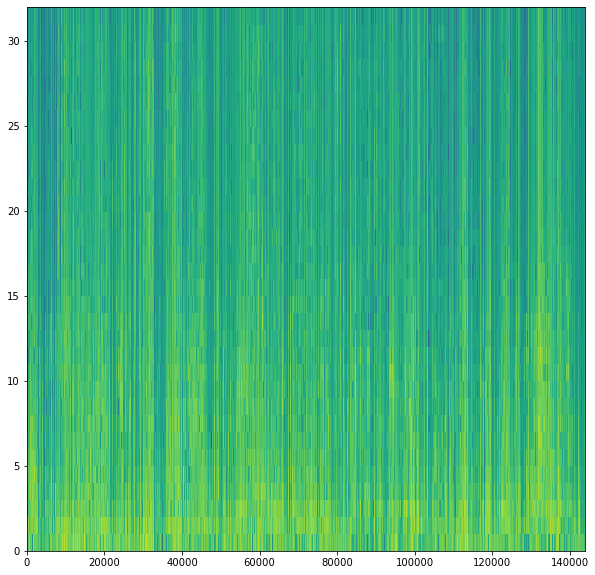

In [8]:
# importing test data
x_test = []
entries = os.listdir('test/')
for entry in tqdm(range(len(entries))):
    sr,data = wavfile.read(os.path.join("test/"+ entries[entry]))
    pad = np.array(np.zeros(80).T)  # padding applied
    data = np.append(data,pad)
    window = signal.hamming(400)  # window for applying FFT
    for i in range(0,len(data)-WINDOW+SHIFT,SHIFT):
        temp = np.array(data[i:i+400]).astype(float)
        #print(window.shape)
        temp = temp * window
        temp_fft = np.log(np.abs(fft(temp,64)[:32]))  # 64 component magnitude FFT
        # concatenate the vectors now
        if entry==0 and i==0:
            Test = temp_fft.T.reshape(32,1)
            continue
        Test = np.concatenate((Test,temp_fft.reshape(32,1)),axis=1)

plt.figure(figsize=(10,10))
print(Test.shape)
plt.pcolormesh(Test)

## Storing the audio files as a binary sequence, Music = 1, Speech = 0

In [9]:
y_music = []
y_speech = []
for i,entry in enumerate(entries):
    if entry[0] == 'm':  # music
        y_music.append(i)
    else:                # speech
        y_speech.append(i)

# create a boolean 1-D array which stores 1 in the index of music file, and 0 corresponding to speech file. 
print("Printing the indices in which thew audio files are stored .")
print("Music")
print(y_music)
print("Speech")
print(y_speech)
y_test = [0 for i in range(48)] # initialising with 0
for i in range(len(y_music)):  # set 1 in the indices of music file
    y_test[y_music[i]] = 1
    
#y_test = np.array(y_test)

Printing the indices in which thew audio files are stored .
Music
[0, 3, 4, 5, 6, 10, 12, 14, 15, 18, 19, 20, 21, 23, 24, 31, 35, 37, 38, 40, 41, 43, 44, 45]
Speech
[1, 2, 7, 8, 9, 11, 13, 16, 17, 22, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 39, 42, 46, 47]


# K-Means clustering implementation

In [10]:
def K_means(n_classes,X_data):

    #X_data ==> data arranged in column wise fashion, X has the feature vectors in row-wise fashion
    X = X_data.T.copy() # X has data data vectors stacked in rows

    old_mew = np.zeros((n_classes,X.shape[1]))
    mew = []

    for i in range(n_classes):
        mew.append(X[random.randint(0,X.shape[0]-1),:]) # initialising means with a random point

    mew = np.array(mew)

    D = np.zeros((X.shape[0],n_classes))   # Distance matrix initialised with 0

    #print(D)
    k_iter = 0
    while True:
        print("Distance matrix calculation....")
        for i in tqdm(range(X.shape[0])):
            dist = 1e14
            index = 0
            for j in range(n_classes):
                D[i,j] = 0
                if dist > np.dot(X[i,:] - mew[j], X[i,:] - mew[j]):
                    dist = np.dot(X[i,:] - mew[j], X[i,:] - mew[j])
                    index = j
            D[i,index] = 1
            
        print(D)
        print("Update mean...")
        for i in tqdm(range(n_classes)):
            mew[i] = np.mean(X[D[:,i] == 1])#/np.sum(D[:,i])


        flag = False 
        for i in range(n_classes):
            if np.abs(np.dot(old_mew[i],old_mew[i]) - np.dot(mew[i],mew[i])) > 1e-1:
                flag = True
                break

        if flag == False:
            return mew,D

        old_mew = mew.copy()
        k_iter += 1
        if k_iter > 20:    # keeping bound in the number of iterations for large dimensions
            return mew,D
        



# Implementation of EM algorithm using full covariance matrix 

In [11]:
def EM_Algorithm_using_full_covariance(n_components,X_data):
    # initialisation before EM algo
    
    X = X_data.T.copy()

    N = X.shape[0]

    means,D = K_means(n_components,X_data) # data vectors are columns

    # data vectors are rows in X_data

    # covariances , sigma.shape = (n_components,32,32)
    sigma = []
    for i in range(n_components):
        sigma.append(np.matmul((X - means[i]).T,X - means[i]))
    sigma = np.array(sigma)

    # priors
    pi = []
    for i in range(n_components):
        pi.append(X[D[:,i]==1].shape[0]/N)
    pi = np.array(pi)
    print(pi)

    # class conditionals
    gamma = []
    for i in range(n_components):
        gamma.append(np.zeros((N,)))
    gamma = np.array(gamma)  # shape = (n_components,N)

    M_variate = np.zeros((N,n_components))
    for i in tqdm(range(n_components)):
        M_variate[:,i] = multivariate_normal.pdf(X, mean=means[i], cov=sigma[i],allow_singular = True)


    # EM algorithm for n_components
    n_iter = 50
    likelihood = []
    N = X.shape[0]
    for i in tqdm(range(n_iter)):

        print("E-step") 
        M_variate = pi.reshape(1,n_components) * M_variate
        gamma = M_variate * ((M_variate @ np.ones((n_components,1))) ** -1)


        print("M step")
        
        # Mean updation
        means = (X.T @ gamma) * (((gamma.T  @ np.ones((N,1))).T) ** -1 ) #  shape = (32,n_components)
        
        # Covariance matrix updation
        for i in tqdm(range(n_components)):
            x = gamma.T[i]
            sigma[i] = ((X.T - means[:,i].reshape(32,1)) * x.reshape(1,N)) @ (X - means[:,i].T)
            sigma[i] = sigma[i] / np.sum(x) 
        
        # prior probabilities updation
        pi = np.mean(gamma,axis=0)    
        print("Prior values :",pi)   
        print("Multivariate...")
        for i in tqdm(range(n_components)):
            M_variate[:,i] = multivariate_normal.pdf(X, mean=means[:,i], cov=sigma[i],allow_singular = True)


        print("Likelihood evaluation")    

        like = np.sum(np.log((pi.reshape(1,n_components) * M_variate) @ np.ones((n_components,1)))) # same as np.sum with axis=1
        print("Log Likelihood = ",like)                                                              
        likelihood.append(like)


    plt.plot(range(len(likelihood)),likelihood, color='b')
    plt.title("Log Likelihood")
    plt.xlabel("Iterations")
    plt.ylabel("Likelihood value")
    plt.show()
    
    return means,sigma,pi
    

# Implementation of EM algorithm using diagonal covariance matrix

In [12]:
def EM_Algorithm_using_diagonal_covariance(n_components,X_data):
    # initialisation before EM
    
    # K-means returns the means of the clusters
    means,D = K_means(n_components,X_data) # data vectors are columns in X_data
    
    X = X_data.T.copy() # data vectors are rows in X
    
    N = X.shape[0]

    sigma = []
    for i in range(n_components):
        sigma.append(np.matmul((X - means[i]).T,X - means[i]))
    sigma = np.array(sigma)

    # priors
    pi = []
    for i in range(n_components):
        pi.append(X[D[:,i]==1].shape[0]/N)
    pi = np.array(pi)
    print(pi)

    # posteriors
    gamma = []
    for i in range(n_components):
        gamma.append(np.zeros((N,)))
    gamma = np.array(gamma)  # shape = (n_components,N)

    M_variate = np.zeros((N,n_components))
    for i in tqdm(range(n_components)):
        M_variate[:,i] = multivariate_normal.pdf(X, mean=means[i], cov=sigma[i],allow_singular = True)

    # Em algorithm for n_components
    
    n_iter = 50
    likelihood = []
    
    for i in tqdm(range(n_iter)):

        print("E-step") 
        M_variate = pi.reshape(1,n_components) * M_variate
        gamma = M_variate * ((M_variate @ np.ones((n_components,1))) ** -1)


        print("M step")
        
        # update means
        means = (X.T @ gamma) * (((gamma.T  @ np.ones((N,1))).T) ** -1 ) # (32,n_components)
        
        # update covariance matrices
        for i in tqdm(range(n_components)):
            x = gamma.T[i]
            sigma[i] = ((X.T - means[:,i].reshape(32,1)) * x.reshape(1,N)) @ (X - means[:,i].T)
            sigma[i] = sigma[i] / np.sum(x)

        # update priors probabilities
        pi = np.mean(gamma,axis=0)    
        print("Prior values:",pi)   
        print("Multivariate...")
        for i in tqdm(range(n_components)):
            M_variate[:,i] = multivariate_normal.pdf(X, mean=means[:,i], cov=np.diag(np.diag(sigma[i])),allow_singular = True)


        print("Likelihood evaluation")    

        like = np.sum(np.log((pi.reshape(1,n_components) * M_variate) @ np.ones((n_components,1))))
        print("Log Likelihood = ",like)                                                              
        likelihood.append(like)


    plt.plot(range(len(likelihood)),likelihood, color='b')
    plt.title("Log Likelihood")
    plt.xlabel("Iterations")
    plt.ylabel("Likelihood value")
    plt.show()
    
    return means,sigma,pi


## 2 mixtures with full covariance for Speech data

Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



[0.49919973 0.50080027]


E-step
M step



Prior values : [0.52868129 0.47131871]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866205.011391592
E-step
M step



Prior values : [0.52868129 0.47131871]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866205.0113849635
E-step
M step



Prior values : [0.52868129 0.47131871]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866205.0113091795
E-step
M step



Prior values : [0.52868129 0.47131871]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866205.009994417
E-step
M step



Prior values : [0.52868129 0.47131871]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866204.9695188617
E-step
M step



Prior values : [0.52868127 0.47131873]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866203.2432586895
E-step
M step



Prior values : [0.52868038 0.47131962]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866122.3507202985
E-step
M step



Prior values : [0.52862933 0.47137067]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3862509.577543828
E-step
M step



Prior values : [0.52448714 0.47551286]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3785584.784148016
E-step
M step



Prior values : [0.48309502 0.51690498]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3621591.675893693
E-step
M step



Prior values : [0.54266309 0.45733691]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3571717.539699943
E-step
M step



Prior values : [0.60861719 0.39138281]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3537904.9831282706
E-step
M step



Prior values : [0.65500579 0.34499421]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3517928.396262382
E-step
M step



Prior values : [0.68626355 0.31373645]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3507708.85713908
E-step
M step



Prior values : [0.70735525 0.29264475]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3502729.3848887878
E-step
M step



Prior values : [0.72183348 0.27816652]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3500264.9647400873
E-step
M step



Prior values : [0.73188896 0.26811104]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3499023.183327968
E-step
M step



Prior values : [0.73893819 0.26106181]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3498390.18762993
E-step
M step



Prior values : [0.74392308 0.25607692]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3498063.7535089813
E-step
M step



Prior values : [0.74747306 0.25252694]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497894.1976982113
E-step
M step



Prior values : [0.7500112 0.2499888]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497806.068759942
E-step
M step



Prior values : [0.75182966 0.24817034]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497760.3194754366
E-step
M step



Prior values : [0.7531343 0.2468657]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497736.5842843372
E-step
M step



Prior values : [0.75407142 0.24592858]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497724.2670610743
E-step
M step



Prior values : [0.75474528 0.24525472]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497717.870907014
E-step
M step



Prior values : [0.75523027 0.24476973]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497714.5470773634
E-step
M step



Prior values : [0.75557959 0.24442041]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497712.818713095
E-step
M step



Prior values : [0.75583132 0.24416868]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497711.9195176326
E-step
M step



Prior values : [0.75601282 0.24398718]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497711.4515201654
E-step
M step



Prior values : [0.75614372 0.24385628]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497711.2078734357
E-step
M step



Prior values : [0.75623814 0.24376186]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497711.0809996366
E-step
M step



Prior values : [0.75630627 0.24369373]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497711.0149223274
E-step
M step



Prior values : [0.75635543 0.24364457]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.980504532
E-step
M step



Prior values : [0.7563909 0.2436091]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9625757704
E-step
M step



Prior values : [0.75641651 0.24358349]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.95323583
E-step
M step



Prior values : [0.75643499 0.24356501]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.948370001
E-step
M step



Prior values : [0.75644832 0.24355168]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9458349664
E-step
M step



Prior values : [0.75645795 0.24354205]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.944514217
E-step
M step



Prior values : [0.7564649 0.2435351]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.943826096
E-step
M step



Prior values : [0.75646991 0.24353009]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.943467575
E-step
M step



Prior values : [0.75647353 0.24352647]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.94328078
E-step
M step



Prior values : [0.75647615 0.24352385]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9431834556
E-step
M step



Prior values : [0.75647803 0.24352197]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9431327474
E-step
M step



Prior values : [0.75647939 0.24352061]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9431063263
E-step
M step



Prior values : [0.75648038 0.24351962]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.943092561
E-step
M step



Prior values : [0.75648109 0.24351891]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.943085389
E-step
M step



Prior values : [0.7564816 0.2435184]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9430816523
E-step
M step



Prior values : [0.75648197 0.24351803]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9430797044
E-step
M step



Prior values : [0.75648223 0.24351777]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9430786897
E-step
M step



Prior values : [0.75648243 0.24351757]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3497710.9430781626



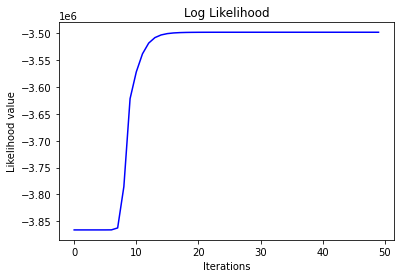

In [13]:
means,sigma,pi = EM_Algorithm_using_full_covariance(2,Speech)

## Predict the posterior values for each vector in spectrogram of test data applying speech parameters (full covariance)

In [14]:
n_components = 2
test_speech_posterior = np.zeros((Test.shape[1],n_components)) #test_speech_posterior.shape = (143952,n_components = 2)

for i in tqdm(range(n_components)):
    test_speech_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=means[:,i], cov=sigma[i],allow_singular = True)

test_speech_posterior = pi.reshape(1,n_components) * test_speech_posterior
print(test_speech_posterior.shape)


(143952, 2)


## 2 mixtures with full covariance for Music data

Distance matrix calculation....



[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



[0.42525008 0.57474992]


E-step
M step



Prior values : [0.37156253 0.62843747]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.4220107268
E-step
M step



Prior values : [0.37156253 0.62843747]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.4220063062
E-step
M step



Prior values : [0.37156253 0.62843747]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.421711703
E-step
M step



Prior values : [0.37156253 0.62843747]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.3986294577
E-step
M step



Prior values : [0.37156258 0.62843742]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613451.5589058828
E-step
M step



Prior values : [0.37156662 0.62843338]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613306.944915996
E-step
M step



Prior values : [0.37191471 0.62808529]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3604014.216952545
E-step
M step



Prior values : [0.39847148 0.60152852]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3417851.6772257863
E-step
M step



Prior values : [0.51018809 0.48981191]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3209267.842959416
E-step
M step



Prior values : [0.45136842 0.54863158]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3160933.345466149
E-step
M step



Prior values : [0.40227669 0.59772331]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3134922.9809969845
E-step
M step



Prior values : [0.36669562 0.63330438]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3120182.3935165755
E-step
M step



Prior values : [0.34121781 0.65878219]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3111980.7672077822
E-step
M step



Prior values : [0.32276136 0.67723864]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3107399.876893787
E-step
M step



Prior values : [0.30935055 0.69064945]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3104849.6915238434
E-step
M step



Prior values : [0.29945431 0.70054569]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3103397.9855803503
E-step
M step



Prior values : [0.29204895 0.70795105]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3102553.375730837
E-step
M step



Prior values : [0.28646418 0.71353582]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3102057.918076226
E-step
M step



Prior values : [0.28221973 0.71778027]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101764.091280696
E-step
M step



Prior values : [0.27896662 0.72103338]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101587.6787587404
E-step
M step



Prior values : [0.27645807 0.72354193]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101481.01917657
E-step
M step



Prior values : [0.27451684 0.72548316]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101416.3711126116
E-step
M step



Prior values : [0.27301162 0.72698838]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101377.1477237414
E-step
M step



Prior values : [0.27184292 0.72815708]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101353.330083112
E-step
M step



Prior values : [0.27093451 0.72906549]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101338.8537461814
E-step
M step



Prior values : [0.27022774 0.72977226]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101330.0463081948
E-step
M step



Prior values : [0.26967735 0.73032265]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101324.6826334433
E-step
M step



Prior values : [0.2692484 0.7307516]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101321.413269049
E-step
M step



Prior values : [0.26891388 0.73108612]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101319.4189013024
E-step
M step



Prior values : [0.26865283 0.73134717]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101318.2014904283
E-step
M step



Prior values : [0.26844902 0.73155098]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101317.4579406967
E-step
M step



Prior values : [0.26828984 0.73171016]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101317.0036020977
E-step
M step



Prior values : [0.26816546 0.73183454]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.725881532
E-step
M step



Prior values : [0.26806825 0.73193175]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.5560714398
E-step
M step



Prior values : [0.26799227 0.73200773]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.452218217
E-step
M step



Prior values : [0.26793286 0.73206714]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.388691491
E-step
M step



Prior values : [0.2678864 0.7321136]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.3498267233
E-step
M step



Prior values : [0.26785007 0.73214993]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.3260470764
E-step
M step



Prior values : [0.26782166 0.73217834]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.3114960436
E-step
M step



Prior values : [0.26779943 0.73220057]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.302591474
E-step
M step



Prior values : [0.26778204 0.73221796]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.297141981
E-step
M step



Prior values : [0.26776844 0.73223156]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.293806808
E-step
M step



Prior values : [0.26775781 0.73224219]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.2917655627
E-step
M step



Prior values : [0.26774948 0.73225052]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.2905162172
E-step
M step



Prior values : [0.26774297 0.73225703]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.2897515325
E-step
M step



Prior values : [0.26773788 0.73226212]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.2892834907
E-step
M step



Prior values : [0.26773389 0.73226611]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.28899701
E-step
M step



Prior values : [0.26773078 0.73226922]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.2888216577
E-step
M step



Prior values : [0.26772834 0.73227166]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.288714326
E-step
M step



Prior values : [0.26772643 0.73227357]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3101316.2886486286



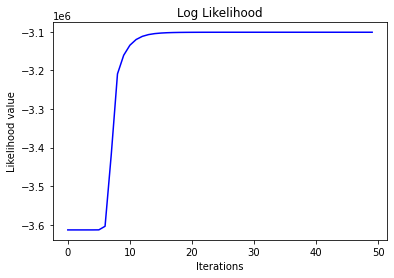

In [15]:
means,sigma,pi = EM_Algorithm_using_full_covariance(2,Music)

## Predict the posterior values for each vector in spectrogram of test data applying Music parameters (full covariance)

In [16]:
n_components = 2
test_music_posterior = np.zeros((Test.shape[1],n_components)) #test_music_posterior.shape = (143952,n_components = 2)

# calculate the likelihood 
for i in tqdm(range(n_components)):
    test_music_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=means[:,i], cov=sigma[i],allow_singular = True)

# calculate the posterior by multiplying prior with likelihood
test_music_posterior = pi.reshape(1,n_components) * test_music_posterior
print(test_music_posterior.shape)


(143952, 2)


## Compare posteriors obtained form from test data calculated above for speech and music specifications and Accuracy calculation

In [17]:
y_pred = np.sum(test_speech_posterior,axis = 1) < np.sum(test_music_posterior,axis=1)

#print(y_pred.shape)
predict=[]
for i in range(0,y_pred.shape[0],2999):
    predict.append(np.mean(y_pred[i:i+2999])>0.5)
    

print("Accuracy= (Matches in prediction) / (Total number of audio files) = ",np.mean(predict==np.array(y_test)))

Accuracy= (Matches in prediction) / (Total number of audio files) =  0.8125


### Accuracy obtained = 81.25 %
### Mismatches = 7 audio files out of 48

# Procedure to predicting Audio files:
1) I have used the following technique for predicting the class of audio files.

2) Firstly, imported the test  dataset of size (32,143952) after applying FFT.

3) Each audio file gets transformed in to a matrix of size (32,2999)

4) After EM training, the class wise means, priors  and covariances are obtained.

5) For each audio file, each vector of size (32,1) is taken and applied the GMM parameters (obtained after training) of the classes to obtain the posterior values. Using the posterior value the class of that vector is assigned. Boolean value is assigned : Music = 1 and Speech = 0.

6) This is done for all the 2999 vectors of the audio file.

7) Now, I find the proportion of vectors assigned the class of MUSIC. This done by taking the mean value of the vector containing the class details. 

8) If the proportion value is more than 0.5, I assign the entire ausio file as Music, else the audio file is tagged as Speech.

9) Following this, I compare my prediction vector with the y_test vector and print the accuracy value.

10) This is done for all the models implemented in the Assignment.


## 2 mixtures with diagonal covariance for Speech data

Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



[0.49917472 0.50082528]


E-step
M step



Prior values: [0.52865414 0.47134586]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6506831.320871442
E-step
M step



Prior values: [0.52865414 0.47134586]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6506831.310623926
E-step
M step



Prior values: [0.52865414 0.47134586]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6506826.436741614
E-step
M step



Prior values: [0.52865179 0.47134821]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6504466.745999965
E-step
M step



Prior values: [0.52780787 0.47219213]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6196149.339030219
E-step
M step



Prior values: [0.51865365 0.48134635]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5391303.402511421
E-step
M step



Prior values: [0.51034969 0.48965031]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5389096.94245442
E-step
M step



Prior values: [0.50569429 0.49430571]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388787.383828081
E-step
M step



Prior values: [0.50260221 0.49739779]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388650.882892882
E-step
M step



Prior values: [0.50053275 0.49946725]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388590.369802977
E-step
M step



Prior values: [0.49915342 0.50084658]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388563.689252743
E-step
M step



Prior values: [0.49823771 0.50176229]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388551.98281632
E-step
M step



Prior values: [0.49763142 0.50236858]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388546.864480128
E-step
M step



Prior values: [0.4972307 0.5027693]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388544.631979771
E-step
M step



Prior values: [0.49696613 0.50303387]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388543.659774488
E-step
M step



Prior values: [0.49679158 0.50320842]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388543.236850019
E-step
M step



Prior values: [0.49667647 0.50332353]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388543.053000399
E-step
M step



Prior values: [0.49660058 0.50339942]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.973116075
E-step
M step



Prior values: [0.49655056 0.50344944]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.938416204
E-step
M step



Prior values: [0.4965176 0.5034824]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.923346428
E-step
M step



Prior values: [0.49649588 0.50350412]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.916802656
E-step
M step



Prior values: [0.49648156 0.50351844]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.913961391
E-step
M step



Prior values: [0.49647213 0.50352787]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.912727804
E-step
M step



Prior values: [0.49646592 0.50353408]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.912192239
E-step
M step



Prior values: [0.49646182 0.50353818]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911959727
E-step
M step



Prior values: [0.49645912 0.50354088]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911858788
E-step
M step



Prior values: [0.49645735 0.50354265]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911814965
E-step
M step



Prior values: [0.49645617 0.50354383]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911795941
E-step
M step



Prior values: [0.4964554 0.5035446]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911787682
E-step
M step



Prior values: [0.49645489 0.50354511]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911784097
E-step
M step



Prior values: [0.49645456 0.50354544]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911782539
E-step
M step



Prior values: [0.49645434 0.50354566]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781864
E-step
M step



Prior values: [0.49645419 0.50354581]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781572
E-step
M step



Prior values: [0.4964541 0.5035459]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781444
E-step
M step



Prior values: [0.49645403 0.50354597]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781389
E-step
M step



Prior values: [0.49645399 0.50354601]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781365
E-step
M step



Prior values: [0.49645397 0.50354603]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781356
E-step
M step



Prior values: [0.49645395 0.50354605]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781349
E-step
M step



Prior values: [0.49645394 0.50354606]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781348
E-step
M step



Prior values: [0.49645393 0.50354607]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781347
E-step
M step



Prior values: [0.49645392 0.50354608]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781347
E-step
M step



Prior values: [0.49645392 0.50354608]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781346
E-step
M step



Prior values: [0.49645392 0.50354608]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781347
E-step
M step



Prior values: [0.49645392 0.50354608]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781347
E-step
M step



Prior values: [0.49645391 0.50354609]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781347
E-step
M step



Prior values: [0.49645391 0.50354609]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781346
E-step
M step



Prior values: [0.49645391 0.50354609]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.9117813455
E-step
M step



Prior values: [0.49645391 0.50354609]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.9117813455
E-step
M step



Prior values: [0.49645391 0.50354609]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781346
E-step
M step



Prior values: [0.49645391 0.50354609]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5388542.911781346



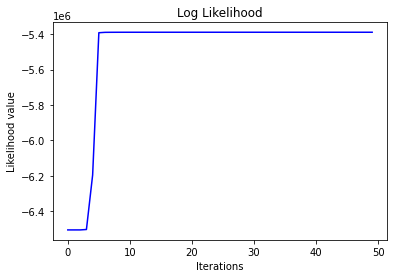

In [18]:
means,sigma,pi = EM_Algorithm_using_diagonal_covariance(2,Speech)
# likelihood graph at the end

## Predict the posterior values for each vector in spectrogram of test data applying speech parameters (diagonal covariance)

In [19]:
n_components = 2
test_speech_posterior = np.zeros((Test.shape[1],n_components)) #test_speech_posterior.shape = (143952,n_components = 2)

for i in tqdm(range(n_components)):
    test_speech_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=means[:,i], cov=np.diag(np.diag(sigma[i])),allow_singular = True)

test_speech_posterior = pi.reshape(1,n_components) * test_speech_posterior
print(test_speech_posterior.shape)


(143952, 2)


## 2 mixtures with diagonal covariance for Music data

Distance matrix calculation....



[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Update mean...



[0.42525842 0.57474158]


E-step
M step



Prior values: [0.37157087 0.62842913]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935448.861547359
E-step
M step



Prior values: [0.37157087 0.62842913]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935448.861259915
E-step
M step



Prior values: [0.37157087 0.62842913]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935448.79787862
E-step
M step



Prior values: [0.37157101 0.62842899]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935428.134750286
E-step
M step



Prior values: [0.37161553 0.62838447]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5926166.279813593
E-step
M step



Prior values: [0.38119195 0.61880805]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5377892.181606981
E-step
M step



Prior values: [0.38027996 0.61972004]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4950653.321311901
E-step
M step



Prior values: [0.39944915 0.60055085]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4946179.532209092
E-step
M step



Prior values: [0.41296065 0.58703935]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4943932.901476309
E-step
M step



Prior values: [0.42308137 0.57691863]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4942679.333950407
E-step
M step



Prior values: [0.43063904 0.56936096]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941989.914805825
E-step
M step



Prior values: [0.43621881 0.56378119]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941617.440470348
E-step
M step



Prior values: [0.44031295 0.55968705]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941417.846981144
E-step
M step



Prior values: [0.44330963 0.55669037]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941311.259272133
E-step
M step



Prior values: [0.44550132 0.55449868]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941254.373445487
E-step
M step



Prior values: [0.44710412 0.55289588]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941223.997395912
E-step
M step



Prior values: [0.44827641 0.55172359]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941207.765590689
E-step
M step



Prior values: [0.44913395 0.55086605]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941199.086785019
E-step
M step



Prior values: [0.44976132 0.55023868]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941194.444372887
E-step
M step



Prior values: [0.45022034 0.54977966]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941191.960306811
E-step
M step



Prior values: [0.45055621 0.54944379]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941190.630837361
E-step
M step



Prior values: [0.45080197 0.54919803]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.9191958755
E-step
M step



Prior values: [0.4509818 0.5490182]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.538224605
E-step
M step



Prior values: [0.45111339 0.54888661]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.3342587175
E-step
M step



Prior values: [0.45120969 0.54879031]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.225052463
E-step
M step



Prior values: [0.45128015 0.54871985]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.166579475
E-step
M step



Prior values: [0.45133171 0.54866829]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.135269988
E-step
M step



Prior values: [0.45136945 0.54863055]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.118504896
E-step
M step



Prior values: [0.45139706 0.54860294]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.10952766
E-step
M step



Prior values: [0.45141726 0.54858274]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.104720542
E-step
M step



Prior values: [0.45143205 0.54856795]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.102146416
E-step
M step



Prior values: [0.45144287 0.54855713]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.100768007
E-step
M step



Prior values: [0.45145079 0.54854921]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.100029888
E-step
M step



Prior values: [0.45145658 0.54854342]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.09963463
E-step
M step



Prior values: [0.45146082 0.54853918]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099422974
E-step
M step



Prior values: [0.45146392 0.54853608]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.0993096335
E-step
M step



Prior values: [0.45146619 0.54853381]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.09924894
E-step
M step



Prior values: [0.45146786 0.54853214]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.09921644
E-step
M step



Prior values: [0.45146907 0.54853093]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099199036
E-step
M step



Prior values: [0.45146996 0.54853004]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099189715
E-step
M step



Prior values: [0.45147061 0.54852939]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099184725
E-step
M step



Prior values: [0.45147109 0.54852891]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.0991820535
E-step
M step



Prior values: [0.45147144 0.54852856]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099180622
E-step
M step



Prior values: [0.45147169 0.54852831]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.0991798565
E-step
M step



Prior values: [0.45147188 0.54852812]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099179446
E-step
M step



Prior values: [0.45147202 0.54852798]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099179225
E-step
M step



Prior values: [0.45147212 0.54852788]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099179108
E-step
M step



Prior values: [0.45147219 0.54852781]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099179045
E-step
M step



Prior values: [0.45147224 0.54852776]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.09917901
E-step
M step



Prior values: [0.45147228 0.54852772]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4941189.099178993



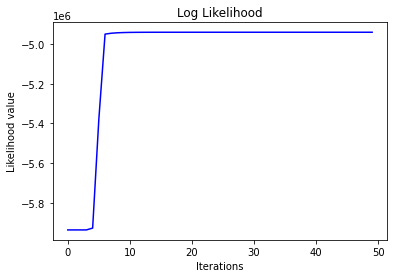

In [20]:
means,sigma,pi = EM_Algorithm_using_diagonal_covariance(2,Music)


## Predict the posterior values for each vector in spectrogram of test data applying Music parameters (Diagonal covariance)

In [21]:
n_components = 2
test_music_posterior = np.zeros((Test.shape[1],n_components)) #test_music_posterior.shape = (143952,n_components = 2)

# calculate likelihoods
for i in tqdm(range(n_components)):
    test_music_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=means[:,i], cov=np.diag(np.diag(sigma[i])),allow_singular = True)

# calculate posteriors by multiplying priors and likelihoods
test_music_posterior = pi.reshape(1,n_components) * test_music_posterior
print(test_music_posterior.shape)


(143952, 2)


## Compare posteriors obtained form from test data calculated above for speech and music specifications and Accuracy calculation

In [22]:
y_pred = np.sum(test_speech_posterior,axis = 1) < np.sum(test_music_posterior,axis=1)

predict=[]
for i in range(0,y_pred.shape[0],2999):
    predict.append(np.mean(y_pred[i:i+2999])>0.5)
    

print("Accuracy= (Matches in prediction) / (Total number of audio files) = ",np.mean(predict==np.array(y_test)))

Accuracy= (Matches in prediction) / (Total number of audio files) =  0.7083333333333334


### Accuracy = 70.83 % for using diagonal covariances
### Mismatches = 14 out of 48 audio files


## 5 mixture component with full covariance for Speech data 

Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



[0.04664055 0.13937979 0.26257919 0.26019507 0.2912054 ]


E-step
M step



Prior values : [0.0337535  0.13850016 0.27512995 0.27998212 0.27263427]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866205.0113914083
E-step
M step



Prior values : [0.0337535  0.13850016 0.27512995 0.27998212 0.27263427]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866205.011375349
E-step
M step



Prior values : [0.0337535  0.13850016 0.27512995 0.27998212 0.27263427]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866205.0108334846
E-step
M step



Prior values : [0.0337535  0.13850017 0.27512995 0.27998212 0.27263427]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866204.9868756607
E-step
M step



Prior values : [0.03375355 0.13850022 0.27512994 0.27998208 0.27263422]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866203.8521386944
E-step
M step



Prior values : [0.03375593 0.13850264 0.27512952 0.27998012 0.27263178]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3866149.873402733
E-step
M step



Prior values : [0.0338686  0.13862089 0.27510871 0.27988515 0.27251665]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3863737.3241079226
E-step
M step



Prior values : [0.03877413 0.14401779 0.27394452 0.27550762 0.26775593]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3782473.2192785973
E-step
M step



Prior values : [0.16755433 0.17571619 0.27046334 0.21051213 0.17575401]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3487345.158489128
E-step
M step



Prior values : [0.22199157 0.14251149 0.26879015 0.19099483 0.17571196]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3424813.6022370746
E-step
M step



Prior values : [0.19420669 0.1724068  0.25658075 0.18650018 0.19030559]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3404433.60962693
E-step
M step



Prior values : [0.17226375 0.18802072 0.24594938 0.18715942 0.20660673]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3390912.661599944
E-step
M step



Prior values : [0.15637446 0.19267338 0.23522294 0.19175917 0.22397006]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3379711.298891414
E-step
M step



Prior values : [0.14449557 0.19258527 0.22401829 0.20240521 0.23649566]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3370959.851803056
E-step
M step



Prior values : [0.13520163 0.19121195 0.21602353 0.21615329 0.2414096 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3365547.778292474
E-step
M step



Prior values : [0.12753949 0.19013029 0.213262   0.22850284 0.24056538]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3362366.9140510825
E-step
M step



Prior values : [0.12104791 0.18951247 0.21413103 0.23833335 0.23697524]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3360262.404965808
E-step
M step



Prior values : [0.11555801 0.18902599 0.21688339 0.24606759 0.23246503]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3358752.7261395
E-step
M step



Prior values : [0.1109244  0.1884768  0.22058763 0.25223475 0.22777642]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3357621.536308462
E-step
M step



Prior values : [0.10699175 0.18782056 0.22482577 0.25720404 0.22315787]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3356742.835998643
E-step
M step



Prior values : [0.10363662 0.18704725 0.22941504 0.26122123 0.21867986]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3356038.4184449213
E-step
M step



Prior values : [0.1007698  0.18614457 0.2342683  0.26446143 0.2143559 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3355456.574567305
E-step
M step



Prior values : [0.09831445 0.1851109  0.23933641 0.2670597  0.21017855]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3354960.08183071
E-step
M step



Prior values : [0.09620139 0.18395477 0.24458649 0.26912686 0.2061305 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3354522.036793875
E-step
M step



Prior values : [0.09437276 0.18268607 0.24999379 0.27075699 0.20219038]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3354123.5257742465
E-step
M step



Prior values : [0.09278255 0.1813115  0.25553896 0.27203063 0.19833636]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3353751.084332245
E-step
M step



Prior values : [0.09139277 0.17983586 0.26120732 0.27301657 0.19454747]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3353394.3791091396
E-step
M step



Prior values : [0.09016976 0.17826339 0.26698861 0.27377375 0.19080449]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3353044.6557091423
E-step
M step



Prior values : [0.08908244 0.1765972  0.27287696 0.27435297 0.18709044]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3352693.6844695355
E-step
M step



Prior values : [0.08810093 0.17483852 0.27887135 0.27479832 0.18339088]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3352332.799834722
E-step
M step



Prior values : [0.0871961  0.17298539 0.28497643 0.27514805 0.17969404]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3351952.0187687976
E-step
M step



Prior values : [0.0863396  0.17103083 0.29120335 0.27543542 0.1759908 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3351539.030410464
E-step
M step



Prior values : [0.08550433 0.1689609  0.29757014 0.27569009 0.17227454]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3351077.758942889
E-step
M step



Prior values : [0.08466581 0.16675228 0.30410124 0.27594001 0.16854066]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3350546.5382594233
E-step
M step



Prior values : [0.08380884 0.1643653  0.31082743 0.27621284 0.1647856 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3349918.686651447
E-step
M step



Prior values : [0.08294372 0.16173028 0.31778621 0.27653559 0.1610042 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3349167.035611552
E-step
M step



Prior values : [0.082095   0.15876837 0.32502148 0.27693218 0.15718298]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3348259.1481951606
E-step
M step



Prior values : [0.08127514 0.1554278  0.33257966 0.27742384 0.15329357]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3347154.321138857
E-step
M step



Prior values : [0.08047554 0.15170685 0.34049953 0.27803395 0.14928413]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3345813.1169810276
E-step
M step



Prior values : [0.07964945 0.14770309 0.34879594 0.27878868 0.14506285]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3344208.0306593548
E-step
M step



Prior values : [0.07871481 0.14362708 0.35743464 0.27970823 0.14051525]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3342349.7159575755
E-step
M step



Prior values : [0.07760331 0.1397114  0.36630459 0.28078723 0.13559347]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3340316.19376191
E-step
M step



Prior values : [0.07622872 0.13616903 0.37520489 0.28197875 0.13041861]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3338210.2904395135
E-step
M step



Prior values : [0.07461558 0.13302739 0.38388317 0.28321237 0.12526149]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3336202.9151940714
E-step
M step



Prior values : [0.07290239 0.13016968 0.39218825 0.28432545 0.12041423]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3334449.4892938444
E-step
M step



Prior values : [0.0711011  0.12760327 0.40018421 0.2850437  0.11606773]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3332950.411737917
E-step
M step



Prior values : [0.06926065 0.12528893 0.40806062 0.28514438 0.11224542]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3331656.7971379603
E-step
M step



Prior values : [0.0674444  0.12317198 0.41599373 0.28451299 0.10887689]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3330520.1193413637
E-step
M step



Prior values : [0.06568306 0.12122837 0.42410384 0.28311511 0.10586961]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3329497.510319013
E-step
M step



Prior values : [0.06398716 0.11943837 0.43245074 0.28098449 0.10313924]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3328556.556652135



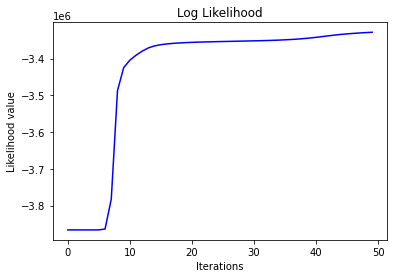

In [23]:
Means,Sigma,Pi = EM_Algorithm_using_full_covariance(5,Speech)

## Predict the posterior values for each vector in spectrogram of test data applying Speech parameters (full covariance, 5 mixture component)

In [24]:
n_components = 5
test_speech_posterior = np.zeros((Test.shape[1],n_components)) #test_speech_posterior.shape = (143952,n_components = 2)

# calculate likelihood
for i in tqdm(range(n_components)):
    test_speech_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=Means[:,i], cov=Sigma[i],allow_singular = True)

# calculate posterior= prior * likelihood
test_speech_posterior = Pi.reshape(1,n_components) * test_speech_posterior
print(test_speech_posterior.shape)


(143952, 5)


## 5 mixture component with full covariance for Music data

Distance matrix calculation....



[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



[0.20901134 0.29775759 0.1464905  0.08780427 0.25893631]


E-step
M step



Prior values : [0.18541172 0.29939609 0.16705453 0.06428571 0.28385195]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.4220106844
E-step
M step



Prior values : [0.18541172 0.29939609 0.16705453 0.06428571 0.28385195]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.4220056348
E-step
M step



Prior values : [0.18541172 0.29939609 0.16705453 0.06428571 0.28385195]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.4216777906
E-step
M step



Prior values : [0.18541172 0.29939609 0.16705453 0.06428571 0.28385195]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613453.396096878
E-step
M step



Prior values : [0.18541172 0.29939603 0.16705449 0.06428582 0.28385194]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613451.3651463725
E-step
M step



Prior values : [0.18541158 0.2993915  0.16705165 0.06429434 0.28385093]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3613295.549269215
E-step
M step



Prior values : [0.18542184 0.29903737 0.16683291 0.06494146 0.28376642]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3603164.0710372967
E-step
M step



Prior values : [0.18750862 0.27723598 0.15410617 0.10334988 0.27779934]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3309156.6311720614
E-step
M step



Prior values : [0.1123975  0.16163161 0.08172329 0.35368676 0.29056083]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3065730.1981680472
E-step
M step



Prior values : [0.18244904 0.15501215 0.08258295 0.30621356 0.27374229]
Multivariate...



Likelihood evaluation
Log Likelihood =  -3012355.724340418
E-step
M step



Prior values : [0.23018198 0.15951169 0.08491416 0.26110574 0.26428642]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2978822.375119581
E-step
M step



Prior values : [0.25128095 0.16894641 0.09391434 0.22789225 0.25796605]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2955197.328783232
E-step
M step



Prior values : [0.25745487 0.17425534 0.11097077 0.20333096 0.25398806]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2937169.057031229
E-step
M step



Prior values : [0.25635089 0.17319899 0.13458495 0.18440256 0.2514626 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2923043.8203244554
E-step
M step



Prior values : [0.25212639 0.17130815 0.15782154 0.16941716 0.24932675]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2912449.1739828424
E-step
M step



Prior values : [0.24702268 0.17231621 0.17574314 0.15740309 0.24751487]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2904708.598111789
E-step
M step



Prior values : [0.24177599 0.17515483 0.18879379 0.14769212 0.24658327]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2898869.5480864746
E-step
M step



Prior values : [0.23661341 0.17793378 0.19887923 0.13961088 0.2469627 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2894202.876186882
E-step
M step



Prior values : [0.23143419 0.17965254 0.20720644 0.13288546 0.24882137]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2890394.1781628653
E-step
M step



Prior values : [0.22624731 0.18013215 0.21429675 0.12726844 0.25205535]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2887245.116947892
E-step
M step



Prior values : [0.22105241 0.17954434 0.22042738 0.12257885 0.25639702]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2884619.28927934
E-step
M step



Prior values : [0.2159666  0.17821163 0.2257531  0.1186006  0.26146807]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2882391.2068278473
E-step
M step



Prior values : [0.21109836 0.1764936  0.23037256 0.11513321 0.26690227]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2880461.974962147
E-step
M step



Prior values : [0.2064509  0.17470788 0.23438546 0.11206275 0.27239301]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2878767.285152703
E-step
M step



Prior values : [0.20198457 0.17308262 0.23789349 0.10933133 0.27770799]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2877265.5935098906
E-step
M step



Prior values : [0.19769956 0.17178445 0.2409691  0.10686892 0.28267797]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2875918.68883775
E-step
M step



Prior values : [0.19363193 0.17093378 0.24365075 0.10460323 0.28718031]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2874694.4698369703
E-step
M step



Prior values : [0.1898141  0.17060571 0.24595684 0.10248258 0.29114077]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2873568.93514906
E-step
M step



Prior values : [0.18623705 0.17083352 0.24791387 0.10048392 0.29453164]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2872522.688055698
E-step
M step



Prior values : [0.18287063 0.17160726 0.24956034 0.09859603 0.29736575]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2871541.6149107814
E-step
M step



Prior values : [0.1796944  0.17287241 0.25093231 0.09680663 0.29969425]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2870625.9634368704
E-step
M step



Prior values : [0.17670166 0.17455422 0.25206174 0.09510058 0.30158181]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2869781.1990971914
E-step
M step



Prior values : [0.17388794 0.17658129 0.25298813 0.09346362 0.30307901]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2869010.514418953
E-step
M step



Prior values : [0.17124377 0.17888648 0.25375442 0.09188598 0.30422934]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2868311.712816643
E-step
M step



Prior values : [0.1687597  0.18141917 0.2543909  0.09036185 0.30506838]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2867678.6363902963
E-step
M step



Prior values : [0.16643073 0.18414277 0.25490897 0.08888757 0.30562996]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2867103.41417805
E-step
M step



Prior values : [0.16424711 0.18701549 0.25531769 0.08746273 0.30595698]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2866584.312067274
E-step
M step



Prior values : [0.16219272 0.18998778 0.25562439 0.08609326 0.30610185]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2866122.615720592
E-step
M step



Prior values : [0.16025198 0.19303034 0.25582616 0.08479179 0.30609973]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2865715.9354726793
E-step
M step



Prior values : [0.15841545 0.19611797 0.25591965 0.08357167 0.30597527]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2865360.691448033
E-step
M step



Prior values : [0.1566834  0.19922709 0.25590405 0.08243968 0.30574579]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2865052.0490343315
E-step
M step



Prior values : [0.15506431 0.20233844 0.25578139 0.08139377 0.30542209]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2864784.356142256
E-step
M step



Prior values : [0.15356946 0.20543726 0.25555739 0.08042524 0.30501066]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2864551.8040543445
E-step
M step



Prior values : [0.15220632 0.2085118  0.25524239 0.07952317 0.30451633]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2864348.8418054115
E-step
M step



Prior values : [0.15097344 0.2115529  0.25485132 0.07867845 0.30394389]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2864170.3464292535
E-step
M step



Prior values : [0.14985978 0.21455467 0.25440145 0.0778853  0.3032988 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2864011.6920006364
E-step
M step



Prior values : [0.14884834 0.21751506 0.25390889 0.07714042 0.30258729]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2863868.8038412216
E-step
M step



Prior values : [0.14792089 0.22043592 0.25338588 0.07644129 0.30181602]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2863738.123885856
E-step
M step



Prior values : [0.14706137 0.22332235 0.25283993 0.07578479 0.30099156]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2863616.5105203516
E-step
M step



Prior values : [0.14625695 0.2261817  0.25227455 0.0751667  0.30012009]
Multivariate...



Likelihood evaluation
Log Likelihood =  -2863501.1664502723



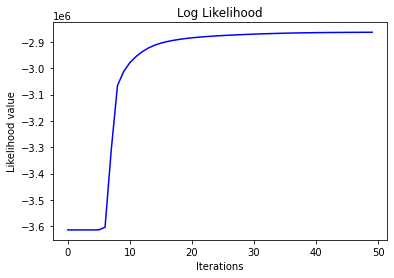

In [25]:
Means,Sigma,Pi = EM_Algorithm_using_full_covariance(5,Music)

## Predict the posterior values for each vector in spectrogram of test data applying Music parameters (full covariance, 5 mixture component)

In [26]:
n_components = 5
test_music_posterior = np.zeros((Test.shape[1],n_components)) #test_music_posterior.shape = (143952,n_components = 2)

# likelihood
for i in tqdm(range(n_components)):
    test_music_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=Means[:,i], cov=np.diag(np.diag(Sigma[i])),allow_singular = True)

# posterior = prior * likelihood
test_music_posterior = Pi.reshape(1,n_components) * test_music_posterior
print(test_music_posterior.shape)


(143952, 5)


## Compare posteriors obtained form from test data calculated above for speech and music specifications and Accuracy calculation

In [27]:
y_pred = np.sum(test_speech_posterior,axis = 1) < np.sum(test_music_posterior,axis=1)

#print(y_pred.shape)
predict=[]
for i in range(0,y_pred.shape[0],2999):
    predict.append(np.mean(y_pred[i:i+2999])>0.5)
    

print("Accuracy= (Matches in prediction) / (Total number of audio files) = ",np.mean(predict==np.array(y_test)))

Accuracy= (Matches in prediction) / (Total number of audio files) =  0.5


### Accuracy = 50%
### Misclassified audio files = 24 out of 48

## 5 mixture component with diagonal covariance for Speech data

Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Update mean...



[0.25668556 0.28304435 0.14874958 0.04591531 0.2656052 ]


E-step
M step



Prior values: [0.26802579 0.26433791 0.14841536 0.03315844 0.28606251]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6506831.320868624
E-step
M step



Prior values: [0.26802579 0.26433791 0.14841536 0.03315844 0.28606251]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6506831.3101920495
E-step
M step



Prior values: [0.26802577 0.26433791 0.14841538 0.03315845 0.2860625 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6506826.473943401
E-step
M step



Prior values: [0.26801591 0.26434156 0.14842138 0.03316289 0.28605826]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6504434.610798833
E-step
M step



Prior values: [0.26333368 0.265802   0.15079741 0.03580871 0.2842582 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -6071334.873908777
E-step
M step



Prior values: [0.12402825 0.22618836 0.28153764 0.1771083  0.19113745]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4791519.494753454
E-step
M step



Prior values: [0.1606968  0.25672936 0.24011864 0.13297357 0.20948164]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4674510.13297278
E-step
M step



Prior values: [0.19120537 0.27064378 0.2167076  0.09931633 0.22212692]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4629118.3383768685
E-step
M step



Prior values: [0.21940049 0.27432331 0.20218458 0.07939446 0.22469716]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4604253.763101863
E-step
M step



Prior values: [0.24130119 0.27407764 0.19267784 0.06904207 0.22290126]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4593245.067678475
E-step
M step



Prior values: [0.25622142 0.27393665 0.18584378 0.06374313 0.22025502]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4588783.68974197
E-step
M step



Prior values: [0.26602506 0.27470192 0.18069093 0.06096919 0.2176129 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4586658.0610304875
E-step
M step



Prior values: [0.27252898 0.276133   0.17667866 0.05947695 0.21518241]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4585381.882851229
E-step
M step



Prior values: [0.27698691 0.27789541 0.17344165 0.05866232 0.21301372]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4584485.484723498
E-step
M step



Prior values: [0.2801756  0.27975652 0.17078755 0.05821548 0.21106485]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4583812.491594742
E-step
M step



Prior values: [0.28257501 0.28156826 0.1685939  0.05797682 0.20928602]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4583292.190176786
E-step
M step



Prior values: [0.28447932 0.28325443 0.1667699  0.05785868 0.20763766]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4582881.91472464
E-step
M step



Prior values: [0.286074   0.28478783 0.165246   0.05781045 0.20608171]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4582551.117468584
E-step
M step



Prior values: [0.28747537 0.28617099 0.16396965 0.05780229 0.2045817 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4582277.838139985
E-step
M step



Prior values: [0.28875046 0.28742086 0.16289817 0.0578167  0.20311381]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4582046.736412029
E-step
M step



Prior values: [0.28993173 0.28855895 0.16199617 0.05784346 0.20166969]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581847.860368381
E-step
M step



Prior values: [0.29103027 0.28960485 0.16123499 0.05787665 0.20025324]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581675.214978641
E-step
M step



Prior values: [0.29204726 0.29057337 0.16059178 0.05791282 0.19887478]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581525.11707685
E-step
M step



Prior values: [0.29298114 0.29147436 0.1600485  0.05794992 0.19754607]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581395.104933803
E-step
M step



Prior values: [0.29383084 0.29231391 0.15959039 0.05798672 0.19627814]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581283.431518136
E-step
M step



Prior values: [0.2945958  0.29309551 0.15920456 0.05802243 0.1950817 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581188.784669052
E-step
M step



Prior values: [0.29527718 0.29382079 0.15887902 0.05805655 0.19396647]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581109.704620327
E-step
M step



Prior values: [0.29588005 0.2944905  0.15860296 0.05808872 0.19293777]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4581044.243886568
E-step
M step



Prior values: [0.29641311 0.29510587 0.15836789 0.05811867 0.19199445]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580990.215183962
E-step
M step



Prior values: [0.29688625 0.29566928 0.15816784 0.05814627 0.19113036]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580945.55296125
E-step
M step



Prior values: [0.29730859 0.29618414 0.15799861 0.05817148 0.19033717]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580908.496847054
E-step
M step



Prior values: [0.29768756 0.29665435 0.15785709 0.0581944  0.1896066 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580877.62516223
E-step
M step



Prior values: [0.29802888 0.29708389 0.15774064 0.05821517 0.18893142]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580851.814103591
E-step
M step



Prior values: [0.29833692 0.29747649 0.15764691 0.05823398 0.1883057 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580830.173941134
E-step
M step



Prior values: [0.29861523 0.29783549 0.15757366 0.05825103 0.1877246 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580811.990181576
E-step
M step



Prior values: [0.29886682 0.29816386 0.15751875 0.05826648 0.18718409]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580796.680244715
E-step
M step



Prior values: [0.29909441 0.29846427 0.15748016 0.05828049 0.18668068]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580783.764460334
E-step
M step



Prior values: [0.29930045 0.2987391  0.15745594 0.05829321 0.1862113 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580772.846034717
E-step
M step



Prior values: [0.29948718 0.29899056 0.15744426 0.05830477 0.18577324]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580763.595989831
E-step
M step



Prior values: [0.29965664 0.29922067 0.15744338 0.05831527 0.18536404]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580755.741252131
E-step
M step



Prior values: [0.29981069 0.2994313  0.15745166 0.05832483 0.18498152]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580749.055086483
E-step
M step



Prior values: [0.29995097 0.29962421 0.15746762 0.05833353 0.18462367]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580743.34933186
E-step
M step



Prior values: [0.30007896 0.299801   0.15748987 0.05834146 0.18428872]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580738.467996229
E-step
M step



Prior values: [0.30019597 0.29996314 0.15751719 0.05834869 0.18397501]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580734.281881724
E-step
M step



Prior values: [0.30030311 0.30011199 0.1575485  0.05835531 0.18368108]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580730.68401974
E-step
M step



Prior values: [0.3004014  0.30024878 0.15758285 0.05836137 0.1834056 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580727.58577664
E-step
M step



Prior values: [0.30049169 0.30037462 0.15761941 0.05836692 0.18314736]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580724.9135436155
E-step
M step



Prior values: [0.30057473 0.30049049 0.15765747 0.05837202 0.18290528]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580722.605953384
E-step
M step



Prior values: [0.30065117 0.30059729 0.15769642 0.05837672 0.1826784 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580720.611576395
E-step
M step



Prior values: [0.30072159 0.30069582 0.15773573 0.05838104 0.18246582]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4580718.887046948



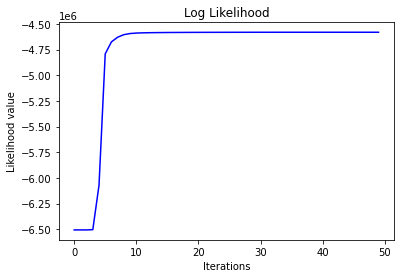

In [28]:
Means,Sigma,Pi = EM_Algorithm_using_diagonal_covariance(5,Speech)

## Predict the posterior values for each vector in spectrogram of test data applying Speech parameters (diagonal covariance, 5 mixture component)

In [29]:
n_components = 5
test_speech_posterior = np.zeros((Test.shape[1],n_components)) #test_speech_posterior.shape = (143952,n_components = 2)

# likelihood
for i in tqdm(range(n_components)):
    test_speech_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=Means[:,i], cov=Sigma[i],allow_singular = True)

# posterior = prior * likelihood
test_speech_posterior = Pi.reshape(1,n_components) * test_speech_posterior
print(test_speech_posterior.shape)


(143952, 5)


## 5 mixture component with diagonal covariance for Music data 

In [ ]:
Means,Sigma,Pi = EM_Algorithm_using_diagonal_covariance(5,Music)

Distance matrix calculation....



[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



Distance matrix calculation....



[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Update mean...



[0.29320607 0.27128209 0.07956819 0.19378126 0.16216239]


E-step
M step



Prior values: [0.29197447 0.29562462 0.0577025  0.16986815 0.18483025]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935448.861545066
E-step
M step



Prior values: [0.29197447 0.29562462 0.0577025  0.16986815 0.18483025]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935448.860832573
E-step
M step



Prior values: [0.29197447 0.29562462 0.0577025  0.16986815 0.18483025]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935448.681156768
E-step
M step



Prior values: [0.29197425 0.29562431 0.05770272 0.16986805 0.18483067]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5935378.753450818
E-step
M step



Prior values: [0.29189942 0.29553642 0.05784281 0.16980432 0.18491703]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5901172.738467848
E-step
M step



Prior values: [0.29216029 0.29954802 0.11420407 0.14499608 0.14909153]
Multivariate...



Likelihood evaluation
Log Likelihood =  -5007805.112980242
E-step
M step



Prior values: [0.20425775 0.34664442 0.20071135 0.22579833 0.02258814]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4336747.242284614
E-step
M step



Prior values: [0.24566309 0.28480577 0.17217476 0.25151789 0.04583849]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4237904.994516425
E-step
M step



Prior values: [0.25750279 0.26114429 0.15694638 0.23398948 0.09041707]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4208885.224283789
E-step
M step



Prior values: [0.25586771 0.25072711 0.14962596 0.22210567 0.12167355]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4198078.318769242
E-step
M step



Prior values: [0.25199174 0.24534414 0.14580779 0.21381308 0.14304325]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4193138.300349483
E-step
M step



Prior values: [0.24756881 0.24243947 0.14339364 0.20789816 0.15869992]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4190380.816453472
E-step
M step



Prior values: [0.24286655 0.24093394 0.14168865 0.20348235 0.17102851]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4188597.3580499613
E-step
M step



Prior values: [0.23806908 0.24022656 0.1404146  0.20001535 0.18127441]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4187311.819855478
E-step
M step



Prior values: [0.23331518 0.23998536 0.13942919 0.19720115 0.19006912]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4186321.694348065
E-step
M step



Prior values: [0.22869359 0.24002642 0.13864179 0.19489069 0.19774751]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4185540.064707114
E-step
M step



Prior values: [0.22430871 0.24023903 0.13799106 0.19300608 0.20445513]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4184928.7371229106
E-step
M step



Prior values: [0.22026722 0.24054417 0.13743597 0.19148903 0.21026362]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4184460.427783525
E-step
M step



Prior values: [0.21663837 0.24088327 0.13694558 0.19028788 0.2152449 ]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4184108.522619791
E-step
M step



Prior values: [0.21344169 0.24121626 0.1364966  0.18935629 0.21948917]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183846.3396818843
E-step
M step



Prior values: [0.21065799 0.24151833 0.13607341 0.1886513  0.22309897]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183650.136494544
E-step
M step



Prior values: [0.20824638 0.2417778  0.13566677 0.18813352 0.22617553]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183501.4913767474
E-step
M step



Prior values: [0.20615925 0.24199178 0.13527235 0.18776757 0.22880906]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183387.1292087603
E-step
M step



Prior values: [0.20435061 0.24216204 0.13488891 0.18752259 0.23107585]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183297.7020262973
E-step
M step



Prior values: [0.20277915 0.24229252 0.1345167  0.18737252 0.23303912]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183226.6251324867
E-step
M step



Prior values: [0.20140877 0.24238795 0.13415628 0.18729605 0.23475095]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183169.2194741154
E-step
M step



Prior values: [0.20020838 0.2424532  0.13380807 0.1872761  0.23625425]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183122.122931994
E-step
M step



Prior values: [0.19915144 0.24249285 0.13347218 0.18729918 0.23758435]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183082.8917042925
E-step
M step



Prior values: [0.19821543 0.24251108 0.13314843 0.18735468 0.23877039]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183049.729141807
E-step
M step



Prior values: [0.19738132 0.24251159 0.13283638 0.18743425 0.23983647]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4183021.299438966
E-step
M step



Prior values: [0.1966331  0.24249755 0.13253545 0.18753133 0.24080257]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4182996.5981983277
E-step
M step



Prior values: [0.19595731 0.24247167 0.13224496 0.18764074 0.24168532]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4182974.861539264
E-step
M step



Prior values: [0.19534263 0.24243624 0.13196416 0.18775834 0.24249863]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4182955.5016470575
E-step
M step



Prior values: [0.19477957 0.24239315 0.13169228 0.18788085 0.24325415]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4182938.060666053
E-step
M step



Prior values: [0.19426012 0.24234397 0.13142853 0.18800563 0.24396175]
Multivariate...



Likelihood evaluation
Log Likelihood =  -4182922.177443314
E-step
M step


## Predict the posterior values for each vector in spectrogram of test data applying Music parameters (diagonal covariance, 5 mixture component)

In [ ]:
n_components = 5
test_music_posterior = np.zeros((Test.shape[1],n_components)) #test_music_posterior.shape = (143952,n_components = 2)

# likelihood
for i in tqdm(range(n_components)):
    test_music_posterior[:,i] = multivariate_normal.pdf(Test.T, mean=Means[:,i], cov=np.diag(np.diag(Sigma[i])),allow_singular = True)

# posterior = prior * likelihood
test_music_posterior = Pi.reshape(1,n_components) * test_music_posterior
print(test_music_posterior.shape)

## Compare posteriors obtained form from test data calculated above for speech and music specifications and Accuracy calculation

In [ ]:
y_pred = np.sum(test_speech_posterior,axis = 1) < np.sum(test_music_posterior,axis=1)

#print(y_pred.shape)
predict=[]
for i in range(0,y_pred.shape[0],2999):
    predict.append(np.mean(y_pred[i:i+2999])>0.5)
    

print("Accuracy= (Matches in prediction) / (Total number of audio files) = ",np.mean(predict==np.array(y_test)))

### Accuracy = 50 %
## Mismatches = 24 out of 48 audio files